In [10]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from tqdm import trange
from numpy.testing import assert_allclose

import sys

sys.path.insert(0, "../scripts")

from swe_2d import ShallowTwo, ShallowTwoFilter
from statfenics.utils import build_observation_operator

fe.set_log_level(50)

In [2]:
mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(10., 5.), 48, 32)

# physical settings
period = 120.
nu = 1e-6
g = 9.8

# reference values
u_ref = 0.01  # cm/s
length_ref = 0.1  # cylinder
time_ref = length_ref / u_ref
H_ref = length_ref

# compute reynolds number
Re = u_ref * length_ref / nu
print(Re, time_ref)

params = dict(
    nu=1 / Re,
    g=g * length_ref / u_ref**2,
    C=0.,
    H=0.053 / H_ref,
    u_inflow=0.004 / u_ref,
    inflow_period=period / time_ref)
control = dict(
    dt=1e-2,
    theta=0.6,
    simulation="laminar",
    use_imex=False,
    use_les=False)

swe = ShallowTwoFilter(mesh, params, control, comm=fe.MPI.comm_world)

# check that all the dofs line up
assert_allclose(np.unique(swe.W.dofmap().dofs()),
                np.unique(np.concatenate((swe.u_dofs,
                                          swe.v_dofs,
                                          swe.h_dofs))))
swe.setup_form()
swe.setup_solver()

1000.0000000000001 10.0


In [3]:
# setup filter (basically compute prior additive noise covariance)
rho = 5e-2
ell = 2.
stat_params = dict(rho_u=rho, rho_v=rho, rho_h=0.,
                   ell_u=ell, ell_v=ell, ell_h=0.5,
                   k_init_u=16, k_init_v=16, k_init_h=1, k=16)
swe.setup_filter(stat_params)

Obs. operator and noise not parsed: setup for prior run ONLY


[2.34179141e-02 1.29529398e-02 4.82761495e-03 2.19193777e-03
 1.21238929e-03 1.21236781e-03 4.51847380e-04 2.05144071e-04
 1.13465657e-04 4.22927722e-05 2.33914542e-05 2.33872036e-05
 1.91971527e-05 8.71690107e-06 2.18855734e-06 2.18811522e-06]
[2.34179141e-02 1.29529398e-02 4.82761495e-03 2.19193777e-03
 1.21238929e-03 1.21236781e-03 4.51847380e-04 2.05144071e-04
 1.13465657e-04 4.22927722e-05 2.33914542e-05 2.33872036e-05
 1.91971527e-05 8.71690107e-06 2.18855734e-06 2.18811522e-06]


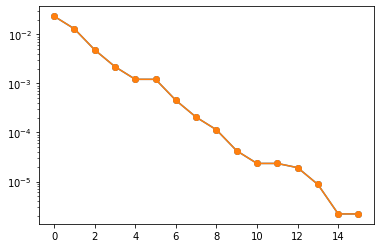

In [4]:
plt.semilogy(swe.Ku_vals, "o-")
plt.semilogy(swe.Kv_vals, "o-")
plt.show()

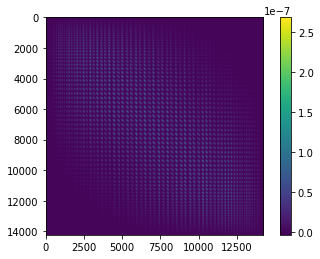

In [5]:
G = swe.G_sqrt @ swe.G_sqrt.T
im = plt.imshow(G)
plt.colorbar(im)
plt.show()

In [6]:
t = 0.
t_final = 0.25 * period / time_ref
nt = np.int32(np.round(t_final / control["dt"]))

means = np.zeros((nt, swe.mean.shape[0]))
variances = np.zeros((nt, swe.mean.shape[0]))

i_dat = 0
for i in trange(nt):
    t += swe.dt
    swe.inlet_velocity.t = t
    swe.prediction_step(t)
    
    means[i, :] = swe.mean.copy()
    variances[i, :] = np.sum(swe.cov_sqrt**2, axis=1)
    
    swe.set_prev()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:50<00:00,  1.30it/s]


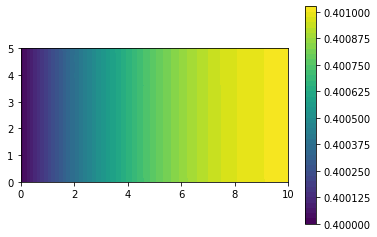

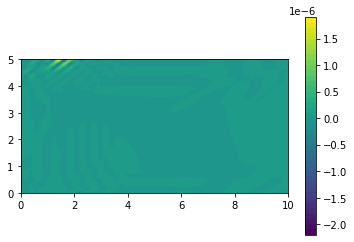

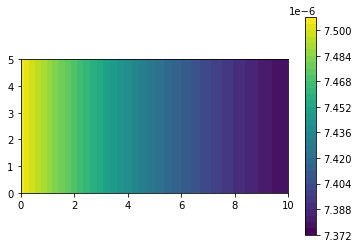

In [7]:
vel, h = swe.du.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

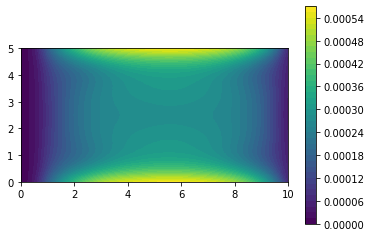

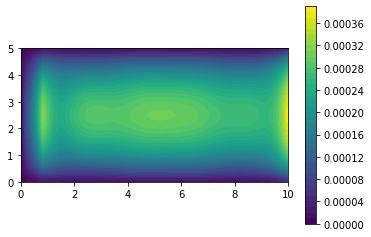

In [8]:
var_v = np.sqrt(np.sum(swe.cov_sqrt**2, axis=1))
var_f = fe.Function(swe.W)
var_f.vector().set_local(var_v)

vel, h = var_f.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

In [9]:
t += swe.dt
%load_ext line_profiler
%lprun -f swe.prediction_step swe.prediction_step(t)
swe.set_prev()

Timer unit: 1e-06 s

Total time: 0.763997 s
File: /home/connor/Projects/20220609-swfe/docs/../scripts/swe_2d.py
Function: prediction_step at line 631

Line #      Hits         Time  Per Hit   % Time  Line Contents
   631                                               def prediction_step(self, t):
   632         1     190653.0 190653.0     25.0          self.solve()
   633         1        253.0    253.0      0.0          self.mean[:] = self.du.vector().get_local()
   634                                           
   635                                                   # TODO(connor): reuse sparsity patterns?
   636         1     170407.0 170407.0     22.3          self.assemble_derivatives()
   637         1     235284.0 235284.0     30.8          self.J_scipy_lu = splu(self.J_scipy.tocsc())  # options=dict(Fact="SamePattern")
   638                                           
   639         1       3210.0   3210.0      0.4          self.cov_sqrt_pred[:, :self.k] = self.J_prev_scipy @ s